In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_breast_cancer

In [110]:
print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1
Is CUDA enabled? False


In [111]:
# For data preprocessing
cancer_data = pd.read_csv('./breast_cancer_bd.csv',sep=',')

device = torch.device('cpu')
cancer_data.iloc[cancer_data['Class'] == 4,-1] = 1
cancer_data.iloc[cancer_data['Class'] == 2,-1] = 0
# delete rows with missing value
#cancer_data.iloc[cancer_data['Bare Nuclei'] == '?',-5] = 1
cancer_data = cancer_data.drop(cancer_data[cancer_data['Bare Nuclei'] == '?'].index)
cancer_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [112]:
# Choose if keep the second feature (uniformity of cell size)
second_feature = True
if second_feature:
    features = 9
    X, y = cancer_data.iloc[:,1:-1], cancer_data.iloc[:,-1]
else:
    features = 8
    X, y = cancer_data.drop(['Uniformity of Cell Size'], axis=1), cancer_data.iloc[:,-1]


X_normed = pd.DataFrame(MinMaxScaler().fit_transform(X))
X = X_normed.astype('float')
y = y.astype('float')
X = X.values
print(X.shape)

(683, 9)


In [113]:
class MLP(nn.Module):
    def __init__(self, features):
        super(MLP, self).__init__()
        self.features = features
        self.input_layer = nn.Linear(self.features, 11)  # 8/9 input neurons to 11 hidden neurons.
        self.hidden_layer = nn.Linear(11, 1)  # 11 hidden neurons to 1 output neuron
    
    def forward(self, x):
        x = torch.tanh(self.input_layer(x))  # Apply tanh activation to the input layer
        x = torch.sigmoid(self.hidden_layer(x))  # Apply sigmoid activation to the output layer for binary classification
        return x

In [114]:
# Initialize the model
model = MLP(features)
model = model.to(device)

criterion = nn.MSELoss()

#for name, param in model.named_parameters():
    #print(name, param)

# Define the optimizer (Adam optimizer).
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [115]:
#  binary-class:stratified k-fold cross validation
kf = StratifiedKFold(3, shuffle=True, random_state=42)

oos_y_base = []
oos_pred_base = []
fold = 0

In [116]:
X = np.array(X)
y = np.array(y)

for train, test in kf.split(X, y):
    fold += 1
    print(f"Fold #{fold}")

    X_train = torch.tensor(X[train], device=device, dtype=torch.float32)
    y_train = torch.tensor(y[train], dtype=torch.float32).to(device)
    X_test = torch.tensor(X[test],device=device, dtype=torch.float32)
    y_test = torch.tensor(y[test], dtype=torch.float32)

    num_epochs = 44

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        #print(loss)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update weights
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        predictions = (predictions > 0.5).float()
        accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
        print(f'Accuracy on test data: {accuracy:.4f}')

    oos_y_base.append(y_test.cpu().numpy())
    oos_pred_base.append(predictions.cpu().numpy())

    if (epoch + 1) % 1000 == 0:
       print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Measure this fold's accuracy
    score = metrics.accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
    print(f"Fold score (accuracy): {score:.4f}")


    
# Build the out-of sample prediction list and calculate the error
oos_y_base = np.concatenate(oos_y_base)
oos_pred_base = np.concatenate(oos_pred_base)

score = metrics.accuracy_score(oos_y_base, oos_pred_base)
print(f"-----------------")
print(f"Final score (accuracy): {score:.4f}")

print("Training completed")


Fold #1
Accuracy on test data: 0.9693
Fold score (accuracy): 0.9693
Fold #2
Accuracy on test data: 0.9825
Fold score (accuracy): 0.9825
Fold #3
Accuracy on test data: 0.9736
Fold score (accuracy): 0.9736
-----------------
Final score (accuracy): 0.9751
Training completed


#### Following is the Lev-Mar version (In thesis)

In [117]:
from torch.optim import Optimizer


def target_func(output):
    return criterion(outputs, y_train.view(-1, 1))

class LevenbergMarquardt(Optimizer):
    def __init__(self, params, lr=1, lambda_=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if lambda_ < 0.0:
            raise ValueError("Invalid lambda value: {}".format(lambda_))
        
        defaults = dict(lr=lr, lambda_=lambda_)
        super(LevenbergMarquardt, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
                
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue

                lr = group['lr']
                lambda_ = group['lambda_']
                if len(param.shape) == 2:
                    d_p = param.grad
                    d_p = torch.reshape(d_p, (-1,))
                    shape0, shape1 = param.shape[0],param.shape[1]
                    param = torch.reshape(param, (-1,))
                    # Compute the approximate Hessian matrix (second derivative)
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update
                    param = torch.reshape(param,(shape0,shape1))
                else:
                    d_p = param.grad
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update

        return loss

model = MLP(features)
lm_optimizer = LevenbergMarquardt(model.parameters(), lr=0.01, lambda_=0.001)
loss_list = []


In [118]:
kf_lm = StratifiedKFold(3, shuffle=True, random_state=42)

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_lm.split(X, y):
    fold += 1
    print(f"Fold #{fold}")

    X_train = torch.tensor(X[train], device=device, dtype=torch.float32)
    y_train = torch.tensor(y[train], dtype=torch.float32).to(device)
    X_test = torch.tensor(X[test],device=device, dtype=torch.float32)
    y_test = torch.tensor(y[test], dtype=torch.float32)

    num_epochs = 61
    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))      
        loss_list.append(loss.item())  
        lm_optimizer.zero_grad()
        loss.backward()
        lm_optimizer.step()
        if (epoch+1)%10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        predictions = (predictions > 0.5).float()
        accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
        print(f'Accuracy on test data: {accuracy:.4f}')
        print('Correct:',torch.sum(predictions.view(-1) == y_test).item(),"Incorrect",y_test.size(0)-torch.sum(predictions.view(-1) == y_test).item())

    oos_y.append(y_test.cpu().numpy())
    oos_pred.append(predictions.cpu().numpy())

    # Measure this fold's accuracy
    score = metrics.accuracy_score(y_test.cpu().numpy(), predictions.cpu().numpy())
    print(f"Fold score (accuracy): {score:.4f}")


    
# Build the out-of sample prediction list and calculate the error
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

score = metrics.accuracy_score(oos_y, oos_pred)
print(f"-----------------")
print(f"Final score (accuracy): {score:.4f}")

print("Training completed")

Fold #1
Epoch [10/61], Loss: 0.0217
Epoch [20/61], Loss: 0.0196
Epoch [30/61], Loss: 0.0189
Epoch [40/61], Loss: 0.0185
Epoch [50/61], Loss: 0.0182
Epoch [60/61], Loss: 0.0180
Accuracy on test data: 0.9737
Correct: 222 Incorrect 6
Fold score (accuracy): 0.9737
Fold #2
Epoch [10/61], Loss: 0.0221
Epoch [20/61], Loss: 0.0217
Epoch [30/61], Loss: 0.0215
Epoch [40/61], Loss: 0.0213
Epoch [50/61], Loss: 0.0212
Epoch [60/61], Loss: 0.0211
Accuracy on test data: 0.9781
Correct: 223 Incorrect 5
Fold score (accuracy): 0.9781
Fold #3
Epoch [10/61], Loss: 0.0174
Epoch [20/61], Loss: 0.0172
Epoch [30/61], Loss: 0.0170
Epoch [40/61], Loss: 0.0169
Epoch [50/61], Loss: 0.0168
Epoch [60/61], Loss: 0.0167
Accuracy on test data: 0.9736
Correct: 221 Incorrect 6
Fold score (accuracy): 0.9736
-----------------
Final score (accuracy): 0.9751
Training completed


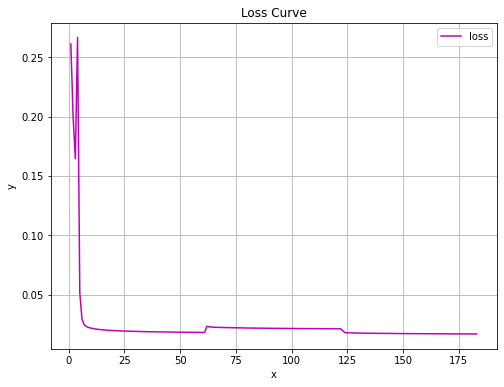

In [119]:
import matplotlib.pyplot as plt

x = np.linspace(1, len(loss_list) ,len(loss_list))
y = loss_list

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='loss', color='m', linewidth=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
